# Machine Learning Project Template
* This notebook provides a structured template for building an end-to-end machine learning project.
* Re-use this notebook througout your learning and in capstone project

Citation Request:
  This dataset is public available for research. The details are described in [Cortez and Morais, 2007]. 
  Please include this citation if you plan to use this database:

  P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. 
  In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, 
  Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, 
  Guimaraes, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. 
  Available at: http://www.dsi.uminho.pt/~pcortez/fires.pdf

1. Title: Forest Fires

2. Sources
   Created by: Paulo Cortez and An?bal Morais (Univ. Minho) @ 2007
   
3. Past Usage:

   P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data.
   In Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, 
   December, 2007. (http://www.dsi.uminho.pt/~pcortez/fires.pdf)
   
   In the above reference, the output "area" was first transformed with a ln(x+1) function.
   Then, several Data Mining methods were applied. After fitting the models, the outputs were
   post-processed with the inverse of the ln(x+1) transform. Four different input setups were
   used. The experiments were conducted using a 10-fold (cross-validation) x 30 runs. Two
   regression metrics were measured: MAD and RMSE. A Gaussian support vector machine (SVM) fed
   with only 4 direct weather conditions (temp, RH, wind and rain) obtained the best MAD value:
   12.71 +- 0.01 (mean and confidence interval within 95% using a t-student distribution). The
   best RMSE was attained by the naive mean predictor. An analysis to the regression error curve
   (REC) shows that the SVM model predicts more examples within a lower admitted error. In effect,
   the SVM model predicts better small fires, which are the majority. 
 
4. Relevant Information:

   This is a very difficult regression task. It can be used to test regression methods. Also,
   it could be used to test outlier detection methods, since it is not clear how many outliers
   are there. Yet, the number of examples of fires with a large burned area is very small.

5. Number of Instances: 517 

6. Number of Attributes: 12 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

7. Attribute information:

   For more information, read [Cortez and Morais, 2007].

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform). 

8. Missing Attribute Values: None

## <b> <font color=green> STEP (1) Problem Definition, Scoping & Framing </font> </b>

### 1.1) Load Libraries
Import all necessary libraries for the project.

In [281]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [282]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from matplotlib.colors import ListedColormap
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, SGDClassifier,Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.datasets import make_moons 
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


### 1.2) Load The Dataset
Load the dataset and display the first few rows.

In [283]:
column_rename = {
    'X': 'grid_x',
    'Y': 'grid_y',
    'FFMC': 'fuel_moisture',
    'DMC': 'duff_moisture', 
    'DC': 'drought_code',
    'ISI': 'spread_index',
    'temp': 'temp',
    'RH': 'humidity',
    'wind': 'wind',
    'rain': 'rain',
    'area': 'area'
}

data = pd.read_csv('forestfires.csv').rename(columns=column_rename)
data.head()

,grid_x,grid_y,month,day,fuel_moisture,duff_moisture,drought_code,spread_index,temp,humidity,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## <b> <font color=green> STEP (2) Data Exploration & Understanding </font> </b>

### 2.1) Descriptive Statistics
Generate summary statistics for the dataset.

In [284]:
data.describe()

,grid_x,grid_y,fuel_moisture,duff_moisture,drought_code,spread_index,temp,humidity,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [285]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   grid_x         517 non-null    int64  
 1   grid_y         517 non-null    int64  
 2   month          517 non-null    object 
 3   day            517 non-null    object 
 4   fuel_moisture  517 non-null    float64
 5   duff_moisture  517 non-null    float64
 6   drought_code   517 non-null    float64
 7   spread_index   517 non-null    float64
 8   temp           517 non-null    float64
 9   humidity       517 non-null    int64  
 10  wind           517 non-null    float64
 11  rain           517 non-null    float64
 12  area           517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [286]:
data.isnull().sum()

grid_x           0
grid_y           0
month            0
day              0
fuel_moisture    0
duff_moisture    0
drought_code     0
spread_index     0
temp             0
humidity         0
wind             0
rain             0
area             0
dtype: int64

### 2.2) Data Visualizations
Visualize the data to identify patterns and relationships.

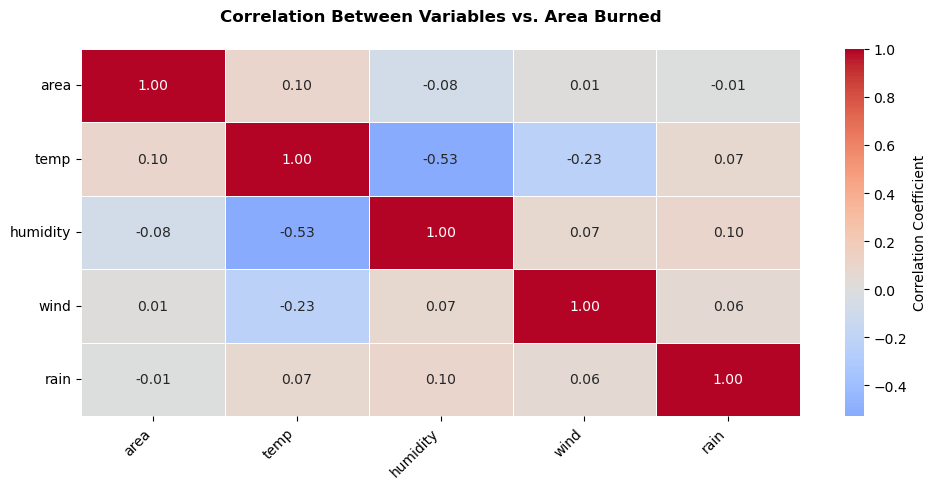

In [287]:
# Visualize correlation between variables
# heat map
numeric_cols = ['area','temp', 'humidity', 'wind', 'rain']
corr_data = data[numeric_cols].corr()
plt.figure(figsize=(10, 5))
sn.heatmap(corr_data, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})
# Improve readability
plt.title('Correlation Between Variables vs. Area Burned', fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

###### 1- Temperature → Burned Area → Strong positive
###### 2- Humidity → Burned Area → Strong negative
###### 3- Wind → Burned Area → Moderate positive
###### 4- Rain → Burned Area → Strong negative

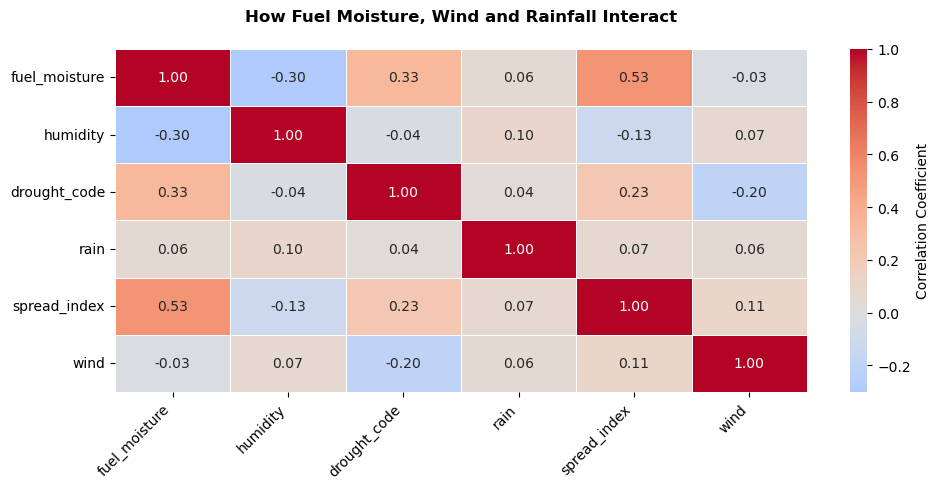

In [288]:
# Visualize correlation between variables
# heat map
numeric_cols = ['fuel_moisture', 'humidity', 'drought_code', 'rain', 'spread_index', 'wind']
corr_data = data[numeric_cols].corr()
plt.figure(figsize=(10, 5))
sn.heatmap(corr_data, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})
# Improve readability
plt.title('How Fuel Moisture, Wind and Rainfall Interact', fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

###### 1- Fine Fuel Moisture vs Humidity → Strong negative
###### 2- Drought Code vs Rainfall → Moderate negative
###### 3- Initial Spread Index vs Wind → Strong positive



C:\Users\Ayaha\AppData\Local\Temp\ipykernel_9272\3094991626.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_area.index, y=avg_area.values, palette='viridis')


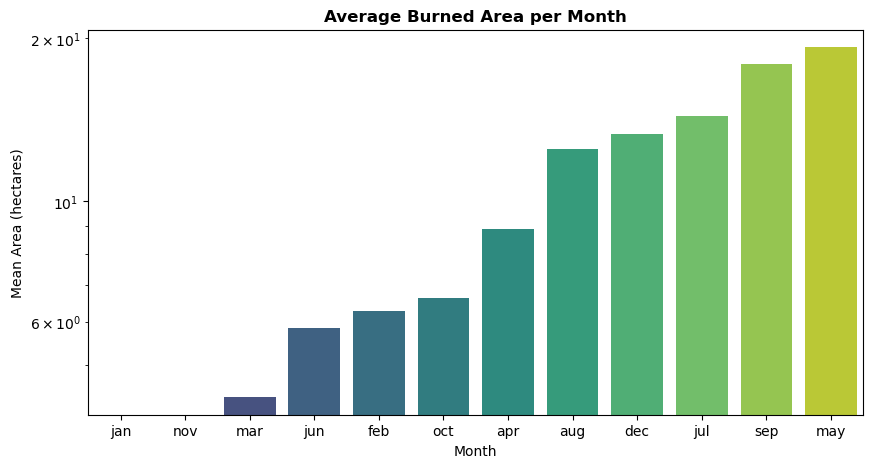

In [289]:
avg_area = data.groupby('month')['area'].mean().sort_values()
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_area.index, y=avg_area.values, palette='viridis')
plt.title('Average Burned Area per Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Mean Area (hectares)')
plt.yscale('log')  # Use if data is skewed
plt.show()

C:\Users\Ayaha\AppData\Local\Temp\ipykernel_9272\1028853700.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='flare')


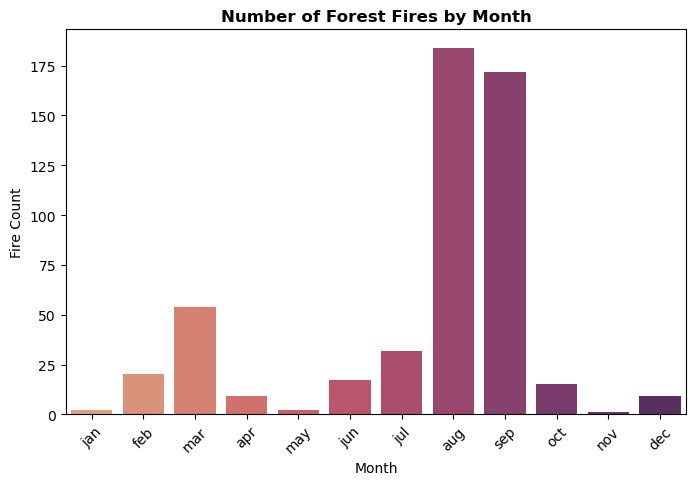

In [290]:
# Count fires per month
monthly_counts = data['month'].value_counts().sort_index()
# Define correct month order (if not already sorted)
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
monthly_counts = monthly_counts.reindex(month_order, fill_value=0)

plt.figure(figsize=(8, 5))
sn.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='flare')
plt.title('Number of Forest Fires by Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Fire Count')
plt.xticks(rotation=45)
plt.show()

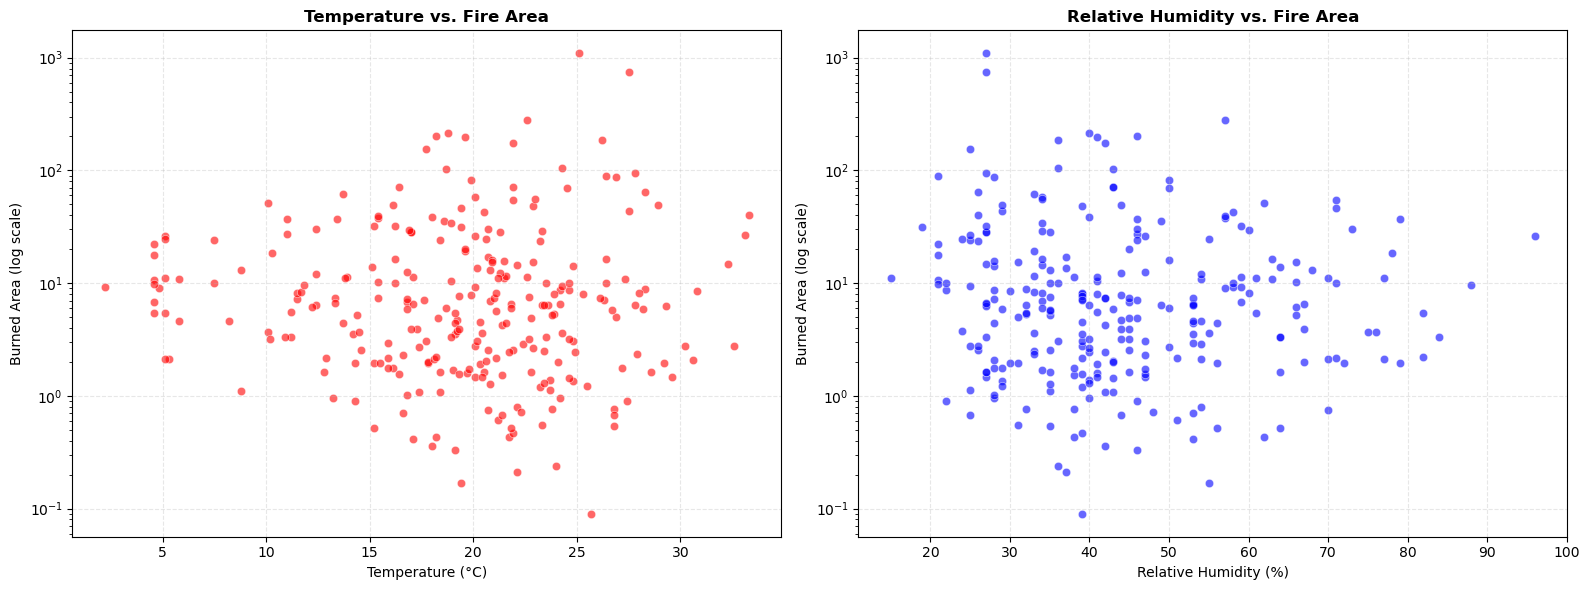

In [291]:
# Filter out rows where area = 0 (unburned areas)
filtered_data = data[data['area'] > 0]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Temperature vs. Fire Size
sns.scatterplot(data=filtered_data, x='temp', y='area', 
                alpha=0.6, color='red', ax=ax1)
ax1.set_title('Temperature vs. Fire Area', fontweight='bold')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Burned Area (hectares)')
ax1.grid(True, linestyle='--', alpha=0.3)

# 2. Humidity vs. Fire Size
sns.scatterplot(data=filtered_data, x='humidity', y='area', 
                alpha=0.6, color='blue', ax=ax2)
ax2.set_title('Relative Humidity vs. Fire Area', fontweight='bold')
ax2.set_xlabel('Relative Humidity (%)')
ax2.set_ylabel('Burned Area (hectares)')
ax2.grid(True, linestyle='--', alpha=0.3)


# Log-transform y-axis if data is skewed
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylabel('Burned Area (log scale)')
ax2.set_ylabel('Burned Area (log scale)')

plt.tight_layout()
plt.show()

## <b> <font color=green> STEP (3) Data Preparation & Feature Engineering </font> </b>

### 3.1) Data Cleaning
Handle missing values and outliers.

In [292]:
## I dont have missing values ..

In [293]:

# Convert month and day to numerical values (for outlier detection)
month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 
             'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
day_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7}

data['month_num'] = data['month'].map(month_map)
data['day_num'] = data['day'].map(day_map)

In [294]:
def remove_outliers(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        if col in ['month', 'day']:  # Skip categorical columns
            continue
            
        # Calculate IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter outliers
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & 
                               (cleaned_df[col] <= upper_bound)]
    
    return cleaned_df

# Select numerical columns for outlier removal
numeric_cols = ['fuel_moisture', 'duff_moisture', 'drought_code', 'spread_index', 'temp', 'humidity', 'wind', 'rain', 'area', 'month_num', 'day_num']

# Remove outliers
data_clean = remove_outliers(data, numeric_cols)
print(f"Original: {len(data)} rows | Cleaned: {len(data_clean)} rows")

Original: 517 rows | Cleaned: 312 rows


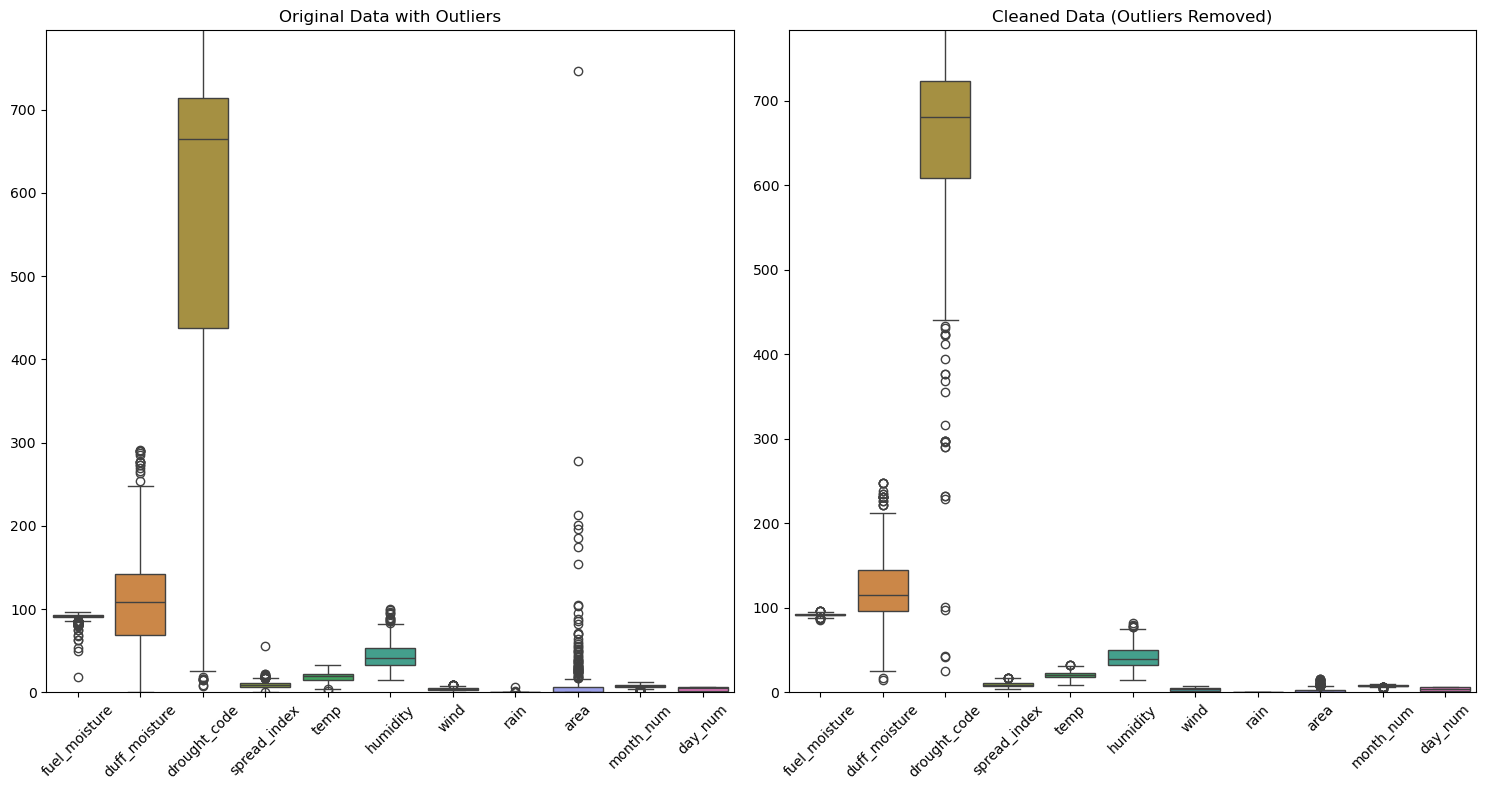

In [295]:
plt.figure(figsize=(15, 8))

# Before cleaning
plt.subplot(1, 2, 1)
sns.boxplot(data=data[numeric_cols])
plt.xticks(rotation=45)
plt.title('Original Data with Outliers')
plt.ylim(0, data[numeric_cols].quantile(0.95).max())  # Adjust scale

# After cleaning
plt.subplot(1, 2, 2)
sns.boxplot(data=data_clean[numeric_cols])
plt.xticks(rotation=45)
plt.title('Cleaned Data (Outliers Removed)')
plt.ylim(0, data_clean[numeric_cols].quantile(0.95).max())

plt.tight_layout()
plt.show()

In [296]:
# Special treatment for area (highly skewed)
Q1 = data['area'].quantile(0.10)  # Use 10th percentile (many zeros)
Q3 = data['area'].quantile(0.90)
IQR = Q3 - Q1
data_clean = data_clean[(data_clean['area'] <= Q3 + 3*IQR)]

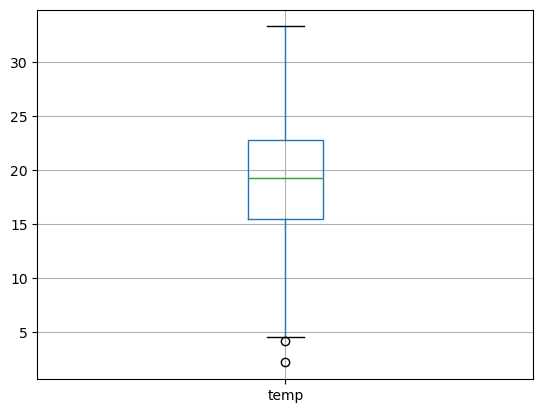

In [297]:
data.boxplot('temp')
plt.show()

### 3.1) Feature Selection
Select the most relevant features for the model.

In [298]:
# Convert categoricals
month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 
             'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
day_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7}

data['month'] = data['month'].map(month_map)
data['day'] = data['day'].map(day_map)

In [299]:
#Step 2: Target Engineering
# For regression: log-transform area (handle skew)
data['log_area'] = np.log1p(data['area'])

# For classification: binary fire occurrence
data['fire_occurrence'] = (data['area'] > 0).astype(int)

In [300]:
# Regression features/target
X_reg = data[['temp', 'wind', 'humidity', 'rain', 'month', 'day','fuel_moisture', 'humidity', 'spread_index', 'wind', 'month']]
y_reg = data['log_area']

In [301]:
# Classification features/target
X_clf = data[['fuel_moisture', 'humidity', 'spread_index', 'wind', 'month','temp', 'wind', 'humidity', 'rain',]]
y_clf = data['fire_occurrence']

### 3.2) Data Transforms
Apply transformations to prepare the data for modeling.

###### Preprocessing Pipelines

In [302]:
# Common numeric transformer (for regression)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [303]:
# Classification-specific (preserves [0,1] range)
clf_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

In [304]:
# Combine transformers
preprocessor_reg = ColumnTransformer([
    ('num', numeric_transformer, ['temp', 'wind', 'humidity', 'rain']),
    ('cat', 'passthrough', ['month', 'day'])  # Already encoded
])

In [305]:
preprocessor_clf = ColumnTransformer([
    ('num', clf_transformer, ['fuel_moisture', 'humidity', 'spread_index', 'wind']),
    ('cat', 'passthrough', ['month'])
])

###### Feature Selection & Dimensionality Reduction

In [306]:
#Feature Selection & Dimensionality Reduction
# Regression pipeline
reg_pipeline = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('selector', SelectKBest(f_regression, k=4)),
    ('pca', PCA(n_components=0.95)),  # Optional
    ('model', RandomForestRegressor())
])

In [307]:
# Classification pipeline
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('selector', SelectKBest(mutual_info_classif, k=3)),
    ('model', RandomForestClassifier())
])

In [308]:
# Fit models
reg_pipeline.fit(X_reg_train, y_reg_train)
clf_pipeline.fit(X_clf_train, y_clf_train)

# Evaluate regression
reg_pred = reg_pipeline.predict(X_reg_test)
rmse = np.sqrt(mean_squared_error(y_reg_test, reg_pred))
print(f"Regression RMSE: {rmse:.4f}")

# Evaluate classification
clf_pred = clf_pipeline.predict(X_clf_test)
accuracy = accuracy_score(y_clf_test, clf_pred)
print(f"Classification Accuracy: {accuracy:.4f}")

ValueError: Selected columns, ['temp', 'wind', 'humidity', 'rain'], are not unique in dataframe

In [309]:
##Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
param_grid = {'model__n_estimators': [100, 200]}
grid_search = GridSearchCV(reg_pipeline, param_grid, cv=5)

## <b> <font color=green> STEP (4)  ML Model Selection & Evaluation </font> </b>

### 4.1) Split-out Validation Dataset
Split the dataset into training and validation sets.

In [310]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [311]:
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

In [312]:
# List of regression models to compare
reg_models = {
    'Linear Regression': LinearRegression()
}
# Train and evaluate each
for name, model in reg_models.items():
    model.fit(X_reg_train, y_reg_train)
    y_pred = model.predict(X_reg_test)
    
    print(f"\n{name} Performance:")
    print(f"MAE: {mean_absolute_error(y_reg_test, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_reg_test, y_pred)):.3f}")
    print(f"R²: {r2_score(y_reg_test, y_pred):.3f}")
    
model = LinearRegression()
model.fit(X_reg_train, y_reg_train)


Linear Regression Performance:
MAE: 1.179
RMSE: 1.461
R²: 0.029


LinearRegression()

In [313]:
# Convert predictions back from log scale
for name, model in reg_models.items():
    sample_X = X_reg_test.iloc[:5]
    sample_y = y_reg_test.iloc[:5]  # Still in log scale
    
    predictions = model.predict(sample_X)
    
    print(f"\n{name} Sample Predictions (in hectares):")
    print(pd.DataFrame({
        'Actual': np.expm1(sample_y),  # Convert log to original scale
        'Predicted': np.expm1(predictions)  # Convert back
    }).round(2))


Linear Regression Sample Predictions (in hectares):
     Actual  Predicted
304    0.00       1.74
501    0.00       2.47
441    1.23       2.20
153    1.46       1.89
503    1.95       1.61


In [314]:
reg_models = {
    'Ridge Regression': Ridge(alpha=0.1)
}
# Train and evaluate each
for name, model in reg_models.items():
    model.fit(X_reg_train, y_reg_train)
    y_pred = model.predict(X_reg_test)
    
    print(f"\n{name} Performance:")
    print(f"MAE: {mean_absolute_error(y_reg_test, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_reg_test, y_pred)):.3f}")
    print(f"R²: {r2_score(y_reg_test, y_pred):.3f}")

model = Ridge(alpha=0.1)
model.fit(X_reg_train, y_reg_train)


Ridge Regression Performance:
MAE: 1.179
RMSE: 1.461
R²: 0.029


Ridge(alpha=0.1)

In [315]:
# Convert predictions back from log scale
for name, model in reg_models.items():
    sample_X = X_reg_test.iloc[:5]
    sample_y = y_reg_test.iloc[:5]  # Still in log scale
    
    predictions = model.predict(sample_X)
    
    print(f"\n{name} Sample Predictions (in hectares):")
    print(pd.DataFrame({
        'Actual': np.expm1(sample_y),  # Convert log to original scale
        'Predicted': np.expm1(predictions)  # Convert back
    }).round(2))


Ridge Regression Sample Predictions (in hectares):
     Actual  Predicted
304    0.00       1.74
501    0.00       2.47
441    1.23       2.20
153    1.46       1.89
503    1.95       1.61


In [316]:
reg_models = {
     'Lasso Regression': Lasso(alpha=0.1)
}
# Train and evaluate each
for name, model in reg_models.items():
    model.fit(X_reg_train, y_reg_train)
    y_pred = model.predict(X_reg_test)
    
    print(f"\n{name} Performance:")
    print(f"MAE: {mean_absolute_error(y_reg_test, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_reg_test, y_pred)):.3f}")
    print(f"R²: {r2_score(y_reg_test, y_pred):.3f}")

model = Lasso(alpha=0.1)
model.fit(X_reg_train, y_reg_train)


Lasso Regression Performance:
MAE: 1.190
RMSE: 1.471
R²: 0.016


Lasso(alpha=0.1)

In [317]:
# Convert predictions back from log scale
for name, model in reg_models.items():
    sample_X = X_reg_test.iloc[:5]
    sample_y = y_reg_test.iloc[:5]  # Still in log scale
    
    predictions = model.predict(sample_X)
    
    print(f"\n{name} Sample Predictions (in hectares):")
    print(pd.DataFrame({
        'Actual': np.expm1(sample_y),  # Convert log to original scale
        'Predicted': np.expm1(predictions)  # Convert back
    }).round(2))


Lasso Regression Sample Predictions (in hectares):
     Actual  Predicted
304    0.00       1.69
501    0.00       2.07
441    1.23       2.16
153    1.46       2.09
503    1.95       1.90


In [318]:
clf_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000)
}
# Train and evaluate each
for name, model in clf_models.items():
    model.fit(X_clf_train, y_clf_train)
    y_pred = model.predict(X_clf_test)
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_clf_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_clf_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_clf_test, y_pred):.3f}")

model = LogisticRegression(max_iter=1000)
model.fit(X_clf_train, y_clf_train)


Logistic Regression Performance:
Accuracy: 0.587
Precision: 0.568
Recall: 0.792


LogisticRegression(max_iter=1000)

In [319]:
for name, model in clf_models.items():
    sample_X = X_clf_test.iloc[:5]
    sample_y = y_clf_test.iloc[:5]  # This is a numpy array
    
    predictions = model.predict(sample_X)
    
    # Create label mappings
    actual_labels = np.where(sample_y == 0, 'No Fire', 'Fire')
    predicted_labels = np.where(predictions == 0, 'No Fire', 'Fire')
    
    print(f"\n{name} Sample Predictions:")
    print(pd.DataFrame({
        'Actual': actual_labels,
        'Predicted': predicted_labels
    }))


Logistic Regression Sample Predictions:
    Actual Predicted
0  No Fire   No Fire
1  No Fire      Fire
2     Fire      Fire
3     Fire      Fire
4     Fire      Fire


In [320]:
clf_models = {
     'SGD Classifier': SGDClassifier()
}
# Train and evaluate each
for name, model in clf_models.items():
    model.fit(X_clf_train, y_clf_train)
    y_pred = model.predict(X_clf_test)
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_clf_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_clf_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_clf_test, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_clf_test, y_pred):.3f}")

model = SGDClassifier()
model.fit(X_clf_train, y_clf_train)


SGD Classifier Performance:
Accuracy: 0.510
Precision: 0.510
Recall: 1.000
F1-Score: 0.675


SGDClassifier()

In [321]:
for name, model in clf_models.items():
    sample_X = X_clf_test.iloc[:5]
    sample_y = y_clf_test.iloc[:5]  # This is a numpy array
    
    predictions = model.predict(sample_X)
    
    # Create label mappings
    actual_labels = np.where(sample_y == 0, 'No Fire', 'Fire')
    predicted_labels = np.where(predictions == 0, 'No Fire', 'Fire')
    
    print(f"\n{name} Sample Predictions:")
    print(pd.DataFrame({
        'Actual': actual_labels,
        'Predicted': predicted_labels
    }))


SGD Classifier Sample Predictions:
    Actual Predicted
0  No Fire      Fire
1  No Fire      Fire
2     Fire      Fire
3     Fire      Fire
4     Fire      Fire


In [322]:
clf_models = {
        'Decision Tree': DecisionTreeClassifier(max_depth=5)
}
# Train and evaluate each
for name, model in clf_models.items():
    model.fit(X_clf_train, y_clf_train)
    y_pred = model.predict(X_clf_test)
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_clf_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_clf_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_clf_test, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_clf_test, y_pred):.3f}")

model = DecisionTreeClassifier(max_depth=5)
model.fit(X_clf_train, y_clf_train)


Decision Tree Performance:
Accuracy: 0.538
Precision: 0.535
Recall: 0.717
F1-Score: 0.613


DecisionTreeClassifier(max_depth=5)

In [323]:
for name, model in clf_models.items():
    sample_X = X_clf_test.iloc[:5]
    sample_y = y_clf_test.iloc[:5]  # This is a numpy array
    
    predictions = model.predict(sample_X)
    
    # Create label mappings
    actual_labels = np.where(sample_y == 0, 'No Fire', 'Fire')
    predicted_labels = np.where(predictions == 0, 'No Fire', 'Fire')
    
    print(f"\n{name} Sample Predictions:")
    print(pd.DataFrame({
        'Actual': actual_labels,
        'Predicted': predicted_labels
    }))


Decision Tree Sample Predictions:
    Actual Predicted
0  No Fire   No Fire
1  No Fire      Fire
2     Fire   No Fire
3     Fire      Fire
4     Fire      Fire


In [324]:
clf_models = {
        'Random Forest': RandomForestClassifier(n_estimators=100)
}
# Train and evaluate each
for name, model in clf_models.items():
    model.fit(X_clf_train, y_clf_train)
    y_pred = model.predict(X_clf_test)
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_clf_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_clf_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_clf_test, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_clf_test, y_pred):.3f}")

model = RandomForestClassifier(n_estimators=100)
model.fit(X_clf_train, y_clf_train)


Random Forest Performance:
Accuracy: 0.567
Precision: 0.574
Recall: 0.585
F1-Score: 0.579


RandomForestClassifier()

In [325]:
for name, model in clf_models.items():
    sample_X = X_clf_test.iloc[:5]
    sample_y = y_clf_test.iloc[:5]  # This is a numpy array
    
    predictions = model.predict(sample_X)
    
    # Create label mappings
    actual_labels = np.where(sample_y == 0, 'No Fire', 'Fire')
    predicted_labels = np.where(predictions == 0, 'No Fire', 'Fire')
    
    print(f"\n{name} Sample Predictions:")
    print(pd.DataFrame({
        'Actual': actual_labels,
        'Predicted': predicted_labels
    }))


Random Forest Sample Predictions:
    Actual Predicted
0  No Fire   No Fire
1  No Fire   No Fire
2     Fire      Fire
3     Fire      Fire
4     Fire      Fire


In [326]:
clf_models = {
           'SVM': SVC(kernel='rbf')
}
# Train and evaluate each
for name, model in clf_models.items():
    model.fit(X_clf_train, y_clf_train)
    y_pred = model.predict(X_clf_test)
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_clf_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_clf_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_clf_test, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_clf_test, y_pred):.3f}")

model =  SVC(kernel='rbf')
model.fit(X_clf_train, y_clf_train)


SVM Performance:
Accuracy: 0.519
Precision: 0.515
Recall: 0.981
F1-Score: 0.675


SVC()

In [327]:
for name, model in clf_models.items():
    sample_X = X_clf_test.iloc[:5]
    sample_y = y_clf_test.iloc[:5]  # This is a numpy array
    
    predictions = model.predict(sample_X)
    
    # Create label mappings
    actual_labels = np.where(sample_y == 0, 'No Fire', 'Fire')
    predicted_labels = np.where(predictions == 0, 'No Fire', 'Fire')
    
    print(f"\n{name} Sample Predictions:")
    print(pd.DataFrame({
        'Actual': actual_labels,
        'Predicted': predicted_labels
    }))


SVM Sample Predictions:
    Actual Predicted
0  No Fire   No Fire
1  No Fire      Fire
2     Fire      Fire
3     Fire      Fire
4     Fire      Fire


In [328]:
clf_models = {
          'KNN': KNeighborsClassifier(n_neighbors=5)
}
# Train and evaluate each
for name, model in clf_models.items():
    model.fit(X_clf_train, y_clf_train)
    y_pred = model.predict(X_clf_test)
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_clf_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_clf_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_clf_test, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_clf_test, y_pred):.3f}")

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_clf_train, y_clf_train)


KNN Performance:
Accuracy: 0.596
Precision: 0.593
Recall: 0.660
F1-Score: 0.625


KNeighborsClassifier()

In [329]:
for name, model in clf_models.items():
    sample_X = X_clf_test.iloc[:5]
    sample_y = y_clf_test.iloc[:5]  # This is a numpy array
    
    predictions = model.predict(sample_X)
    
    # Create label mappings
    actual_labels = np.where(sample_y == 0, 'No Fire', 'Fire')
    predicted_labels = np.where(predictions == 0, 'No Fire', 'Fire')
    
    print(f"\n{name} Sample Predictions:")
    print(pd.DataFrame({
        'Actual': actual_labels,
        'Predicted': predicted_labels
    }))


KNN Sample Predictions:
    Actual Predicted
0  No Fire   No Fire
1  No Fire   No Fire
2     Fire      Fire
3     Fire      Fire
4     Fire      Fire


### 4.2) Test Options and Evaluation Metric
Define the evaluation metric for the model.

In [330]:
clf_models = {
        'Random Forest': RandomForestClassifier(n_estimators=100)
}
# Train and evaluate each
for name, model in clf_models.items():
    model.fit(X_clf_train, y_clf_train)
    y_pred = model.predict(X_clf_test)
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_clf_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_clf_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_clf_test, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_clf_test, y_pred):.3f}")


Random Forest Performance:
Accuracy: 0.548
Precision: 0.556
Recall: 0.566
F1-Score: 0.561


In [331]:
for name, model in clf_models.items():
    sample_X = X_clf_test.iloc[:5]
    sample_y = y_clf_test.iloc[:5]  # This is a numpy array
    
    predictions = model.predict(sample_X)
    
    # Create label mappings
    actual_labels = np.where(sample_y == 0, 'No Fire', 'Fire')
    predicted_labels = np.where(predictions == 0, 'No Fire', 'Fire')
    
    print(f"\n{name} Sample Predictions:")
    print(pd.DataFrame({
        'Actual': actual_labels,
        'Predicted': predicted_labels
    }))


Random Forest Sample Predictions:
    Actual Predicted
0  No Fire   No Fire
1  No Fire   No Fire
2     Fire      Fire
3     Fire      Fire
4     Fire      Fire


In [332]:
y_pred = model.predict(X_clf_test)
accuracy = accuracy_score(y_clf_test, y_pred)
conf_matrix = confusion_matrix(y_clf_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.55
Confusion Matrix:
[[27 24]
 [23 30]]


### 4.3) Spot Check Algorithms
Test multiple algorithms to identify the best-performing one.

In [333]:
# Initialize models 
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'SGD Classifier': SGDClassifier(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

In [334]:
#Evaluation Function with Overfitting Metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train and predict
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Test Accuracy': accuracy_score(y_test, test_pred),
        'Overfitting Gap': accuracy_score(y_train, train_pred) - accuracy_score(y_test, test_pred),
        'Underfitting Score': 1 - accuracy_score(y_train, train_pred)  # How much below perfect training accuracy
    }
    return metrics

In [335]:
#Run Evaluation and Store Results
results = []
for name, model in models.items():
    metrics = evaluate_model(model, X_clf_train, X_clf_test, y_clf_train, y_clf_test)
    metrics['Model'] = name
    results.append(metrics)
    
results_df = pd.DataFrame(results).set_index('Model')

In [336]:
#Display Metrics Table
#Add interpretation columns
results_df['Overfitting Risk'] = np.where(
    results_df['Overfitting Gap'] > 0.1, 'High', 
    np.where(results_df['Overfitting Gap'] > 0.05, 'Medium', 'Low')
)

results_df['Underfitting Risk'] = np.where(
    results_df['Underfitting Score'] > 0.3, 'High',
    np.where(results_df['Underfitting Score'] > 0.15, 'Medium', 'Low')
)

# Format for display
display_df = results_df.style\
    .background_gradient(subset=['Overfitting Gap'], cmap='Oranges')\
    .background_gradient(subset=['Underfitting Score'], cmap='Blues_r')\
    .format({
        'Train Accuracy': '{:.2%}',
        'Test Accuracy': '{:.2%}',
        'Overfitting Gap': '{:.2%}',
        'Underfitting Score': '{:.2%}'
    })

display_df

,Train Accuracy,Test Accuracy,Overfitting Gap,Underfitting Score,Overfitting Risk,Underfitting Risk
Model,,,,,,
Logistic Regression,57.87%,56.73%,1.14%,42.13%,Low,High
SGD Classifier,53.75%,57.69%,-3.94%,46.25%,Low,High
Decision Tree,67.55%,52.88%,14.67%,32.45%,High,High
Random Forest,97.09%,51.92%,45.17%,2.91%,High,Low
SVM,55.93%,52.88%,3.05%,44.07%,Low,High
KNN,68.52%,59.62%,8.91%,31.48%,Medium,High


## <b> <font color=green> STEP (5)  Performance Tuning & Optimization </font> </b>

### 4.1) Algorithm Tuning
Optimize hyperparameters for better performance.

In [337]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Initialize and fit
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_clf_train, y_clf_train)

# Best model
best_rf = grid_rf.best_estimator_
print(f"Best RF params: {grid_rf.best_params_}")
print(f"Best F1: {grid_rf.best_score_:.3f}")

Best RF params: {'class_weight': None, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best F1: 0.640


In [343]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse regularization strength
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_clf_train, y_clf_train)

best_lr = grid_lr.best_estimator_

In [344]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True, class_weight='balanced')
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='f1', n_jobs=-1)
grid_svm.fit(X_clf_train, y_clf_train)

best_svm = grid_svm.best_estimator_

### 4.2) Ensembles
Combine multiple models to improve accuracy.

###### A. Voting Classifier (Combine Best Models)

In [348]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.model_selection import GridSearchCV
# Create ensemble of tuned models
ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('lr', best_lr)
    ],
    voting='soft'  # Uses predict_proba() for better performance
)

ensemble.fit(X_clf_train, y_clf_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     random_state=42)),
                             ('svm',
                              SVC(C=10, class_weight='balanced',
                                  kernel='linear', probability=True)),
                             ('lr',
                              LogisticRegression(C=10, class_weight='balanced',
                                                 max_iter=1000, penalty='l1',
                                                 solver='liblinear'))],
                 voting='soft')

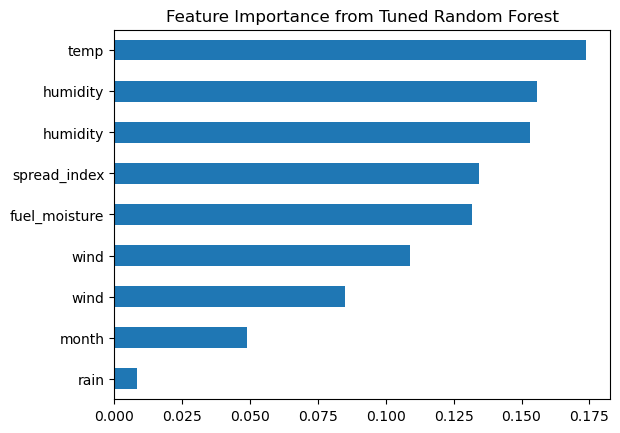

In [349]:
# Plot feature importance
importances = best_rf.feature_importances_
features = X_clf.columns
pd.Series(importances, index=features).sort_values().plot(kind='barh')
plt.title('Feature Importance from Tuned Random Forest')
plt.show()

## <b> <font color=green> STEP (6) Results Interpretation & Deployment </font> </b>

### 6.1) Predictions on Validation Dataset
Make predictions using the validation dataset.

### 6.2) Create Standalone Model on Entire Training Dataset
Train the final model on the entire dataset.

### 6.3) Save Model for Later Use
Save the trained model to a file.